# Описание проекта

Компания «Чётенькое такси» просит нас написать модель, которая будет прогнозировать спрос в аэропортах.
Для выполнения данной задачи они предоставили нам исторические данные о заказах.

Одно из условий, что значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## План выполнения проекта:

1. Загрузка данных, ресемплирование к 1 часу.
2. Анализ данных.
3. Построение модели.
4. Тестирование модели.

### Описание данных
Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка данных

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import Normalizer

import lightgbm

import sklearn.linear_model as linear
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor

import torch

from statsmodels.tsa.seasonal  import seasonal_decompose

import warnings
warnings.filterwarnings('ignore')

Загрузим данные.

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=True)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Так как 10 минут - это слишком маленький промежуток времени, чтобы по нему делать выводы о количестве заказов такси, то проведем ресемплирвоание временного ряда по одному часу.

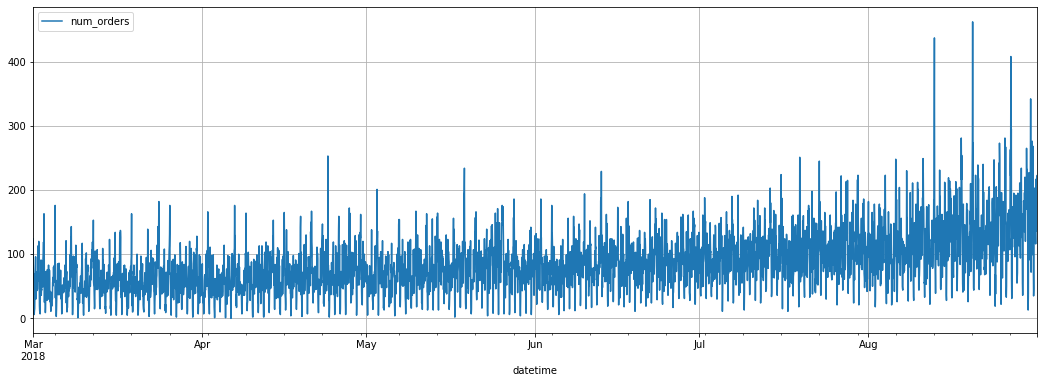

In [5]:
data = data.resample('1H').sum()

ax = data.plot(figsize=(18,6))
ax.grid(True)



# Итоги по разделу 1
Мы получили набор очищенных данных, произвели ресемплирвоание данных, теперь шаг времени в них - 1 час. Так как данные не содержат пропусков, то можем приступить к анализу.

# 2. Анализ
Проанализируем данные. Исследуем время наиболее частого вызова такси.
Чтобы часть тестовых данных не попали в расчетные значения тренировочной, сразу отделим их.

In [6]:
test_index = int(len(data)*(1-0.1))

In [7]:
data['num_orders'].sort_values(ascending=False).head(10)

datetime
2018-08-20 02:00:00    462
2018-08-13 02:00:00    437
2018-08-27 02:00:00    408
2018-08-30 17:00:00    342
2018-08-27 04:00:00    295
2018-08-18 00:00:00    281
2018-08-26 00:00:00    281
2018-08-31 00:00:00    276
2018-08-13 01:00:00    273
2018-08-25 00:00:00    273
Name: num_orders, dtype: int64

Мы видим, что в основном - это ночные часы. Выделим время, как отдельный признак и построим диаграмму вызовов по часам.

In [8]:
data['hour'] = data.index.hour

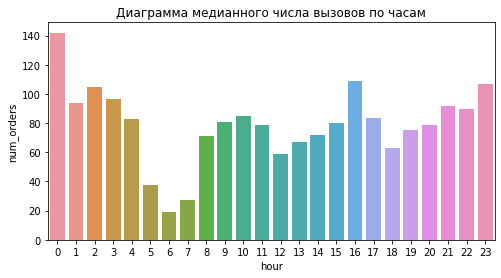

In [9]:
hour_sum = data.groupby('hour').median().sort_values(by='num_orders', ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=hour_sum.index, y=hour_sum['num_orders'])
plt.title('Диаграмма медианного числа вызовов по часам')

plt.show()

Информации о динамике вызовов может добавить информация по дням неделям, добавим её и отобразим на графике

In [10]:
data['day_of_week'] = data.index.dayofweek

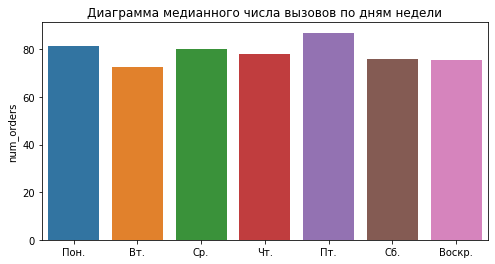

In [11]:
day_week_med = data.groupby('day_of_week').median()

day_name = ['Пон.', 'Вт.', 'Ср.', 'Чт.', 'Пт.', 'Сб.', 'Воскр.']

plt.figure(figsize=(8,4))
sns.barplot(x=day_name, y=day_week_med['num_orders'])
plt.title('Диаграмма медианного числа вызовов по дням недели')
plt.show()

Максимум заказов приходится на пятницу и понедельник, возможно, в это время наибольшее количество рейсов в аэропортах.

Теперь нам не хватает только разбиения по месяцам, повторим процедуру и получим значения вызовов такси по месяцам

In [12]:
data['month'] = data.index.month

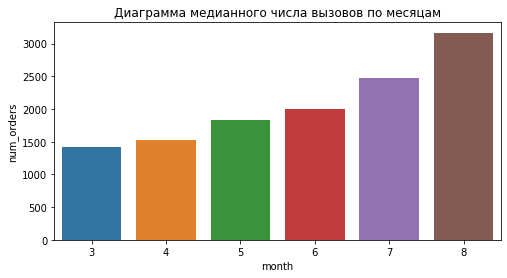

In [13]:
month_med = data.groupby('month').sum()/30

month_name = {1:'Янв.', 2:'Фев.', 3:'Март', 4:'Апр.',
              5:'Май', 6:'Июнь', 7:'Июль', 8:'Авг.',
              9:'Сент.', 10:'Окт.', 11:'Ноябрь', 12:'Дек.'}

plt.figure(figsize=(8,4))
sns.barplot(x=month_med.index, y=month_med['num_orders'])
plt.title('Диаграмма медианного числа вызовов по месяцам')
plt.show()

Как и ожидалось - к лету количество перелетов увеличивается, следовательно количество вызовов такси тоже увеличивается.

Попробуем сгенерировать новые признаки, которые помогут построить более точную модель предсказания.

In [14]:
for i in range(1, 25):
    data['lag_'+str(i)] = data['num_orders'].shift(i)

In [15]:
data['rolling_mean'] = data['num_orders'].shift().rolling(25).mean()
data.dropna(inplace=True)
data['rolling_mean'] = np.round(data['rolling_mean']).astype(int)


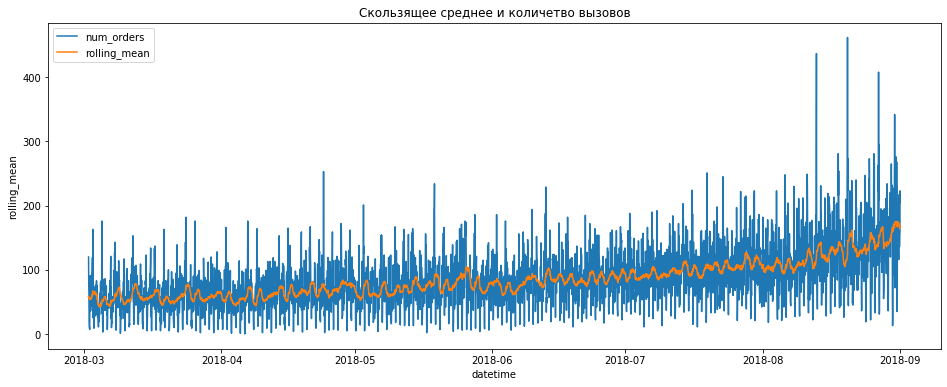

In [16]:
plt.figure(figsize=(16,6))
sns.lineplot(x=data.index, y='num_orders', label="num_orders", data=data)
sns.lineplot(x=data.index, y='rolling_mean', label="rolling_mean", data=data)
plt.title('Скользящее среднее и количетво вызовов')

plt.show()

Изучим сезонность и трэнд наших данны.

In [17]:
decompose = seasonal_decompose(data['num_orders'])

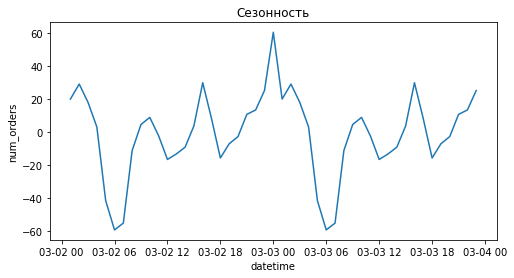

In [18]:
plt.figure(figsize=(8,4))
sns.lineplot(x=decompose.seasonal['2018-03-01':'2018-03-03'].index, y=decompose.seasonal['2018-03-01':'2018-03-03'])
plt.title('Сезонность');

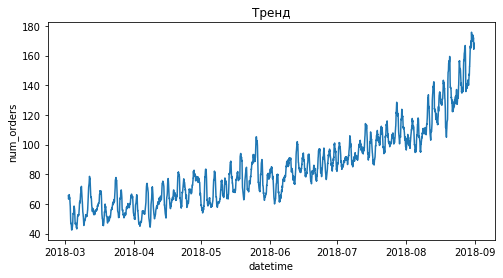

In [19]:
plt.figure(figsize=(8,4))
sns.lineplot(x=decompose.trend.index, y=decompose.trend)
plt.title('Тренд');

# Итоги по разделу 2
Проанализировав данные мы можем прийти к следующим выводам:
- Распределение количества вызовов такси имеют четкую сезонность(если это можно отнести к времени суток), спрос падает:
    - ранним утром(с 02:00-06:00);
    - в обед(с 11:00-12:00);
    - вечером(с 16:00-17:00).
  
  Все остальное время он плавно возрастает и достигает локильных максимумов в 00:00, 10:00 и 16:00.
- Мы можем проследить четкий тренд на возрастание количества заказов к летним месяцам.
- В пятницу и понедельник количество заказов чуть выше, чем в остальные дни, но сильных отличий не наблюдается.

# 3. Обучение
Обучим и подберем гиперпараметры для 3-х моделей:
- Линейной регрессии;
- Catboost;
- RandomForestRegressor.

Перед обучением моделей выделим категориальные признаки и разобьем данные на тестовую и тренировочную выборки.

In [20]:
cat_features = ['month', 'hour', 'day_of_week']

data[cat_features] = data[cat_features].astype("category");

In [21]:
features = data.drop(['num_orders'], axis=1)
target = data['num_orders']

In [22]:
features_train, features_test, target_train, target_test = train_test_split(features,
                                                                            target,
                                                                            test_size=0.1,
                                                                            shuffle=False)

Нормализуем данные.

In [23]:
num_columns = list(features_train.select_dtypes(np.number).columns)

norm = Normalizer()

norm.fit(features_train.loc[:,num_columns])

features_train.loc[:,num_columns] = norm.transform(features_train.loc[:,num_columns])
features_test.loc[:,num_columns] = norm.transform(features_test.loc[:,num_columns])

## 3.1 Линейная регрессия
Построим модель основанную на линейной регрессии.

In [24]:
features_trn, features_val, target_trn, target_val = train_test_split(features_train,
                                                                            target_train,
                                                                            test_size=0.1,
                                                                            shuffle=False)

In [25]:
model = linear.LinearRegression()

model.fit(features_trn, target_trn)

prediction = model.predict(features_val)

print('LinReg model RMSE: {:.2f}'.format(mean_squared_error(prediction,
                                                target_val)**0.5))

LinReg model RMSE: 37.20


Сравним это значение с значением на наивной модели.

In [26]:
dummy_val = np.ones(target_val.shape) * target_trn.median()

print('Dummy models RMSE: {:.2f}'.format(mean_squared_error(dummy_val,
                                                target_val)**0.5))

Dummy models RMSE: 59.12


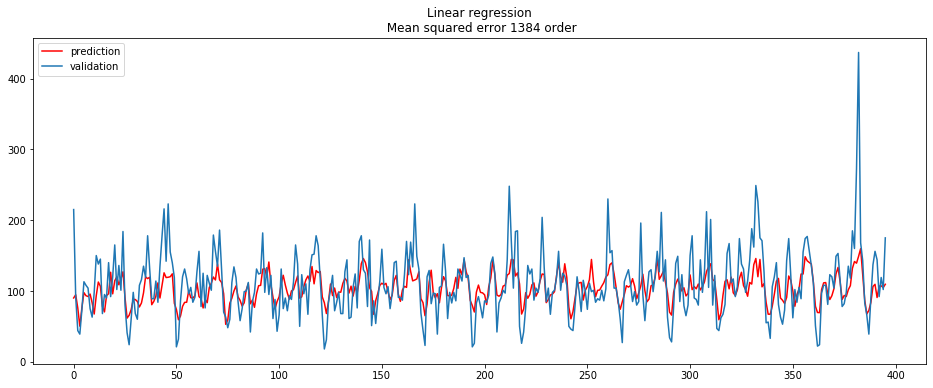

In [27]:
plt.figure(figsize=(16, 6))
plt.plot(prediction, "r", label="prediction")
plt.plot(target_val.values, label="validation")
plt.legend(loc="best")

lin_rmse = mean_squared_error(prediction, target_val)**0.5
plt.title("Linear regression\n Mean squared error {} order".format(round(mean_squared_error(prediction,
                                                                                              target_val))));

Мы получили очень хороший результат на валидационной выборке, но на графике видно, что линейная регрессия очень плохо подстраивается под резкие скачки данных.

## 3.2 Catboost

In [ ]:
model = CatBoostRegressor(task_type="GPU")

grid = {'learning_rate': [0.03, 0.1, 0.3],
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9],
        iterations=[250, 300, 500, 700]}

trainPool = Pool(features_train, 
                  target_train, 
                  cat_features=[0,1,2])

grid_search_result = model.grid_search(grid, trainPool, cv=TimeSeriesSplit(n_splits=4).split(features_train),
                 partition_random_seed=42, shuffle=False)

In [ ]:
print('Max RMSE-mean on validation :',min(grid_search_result['cv_results']['test-RMSE-mean']))



Max RMSE-mean on validation : 29.876909648469447

In [ ]:
grid_search_result['params']

{'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 700,
  'learning_rate': 0.3}

In [28]:
cat_rmse = 29.8769

In [29]:
%%time

grid_search_result = {'depth': 4,
  'l2_leaf_reg': 1,
  'iterations': 700,
  'learning_rate': 0.3}

cat_model = CatBoostRegressor(**grid_search_result, cat_features=[0,1, 2], random_seed=2)
cat_model.fit(features_train, target_train)

0:	learn: 34.8021631	total: 52.3ms	remaining: 36.5s
1:	learn: 31.4019715	total: 56.4ms	remaining: 19.7s
2:	learn: 29.2557214	total: 64.1ms	remaining: 14.9s
3:	learn: 27.8978251	total: 103ms	remaining: 18s
4:	learn: 27.0142073	total: 106ms	remaining: 14.8s
5:	learn: 26.3578190	total: 109ms	remaining: 12.6s
6:	learn: 25.8457561	total: 199ms	remaining: 19.7s
7:	learn: 25.4626554	total: 203ms	remaining: 17.5s
8:	learn: 25.1654141	total: 205ms	remaining: 15.8s
9:	learn: 24.7955489	total: 208ms	remaining: 14.3s
10:	learn: 24.7352133	total: 216ms	remaining: 13.5s
11:	learn: 24.4810748	total: 301ms	remaining: 17.3s
12:	learn: 24.3250304	total: 304ms	remaining: 16s
13:	learn: 24.0938499	total: 307ms	remaining: 15s
14:	learn: 23.9562428	total: 397ms	remaining: 18.1s
15:	learn: 23.8524626	total: 400ms	remaining: 17.1s
16:	learn: 23.7409258	total: 405ms	remaining: 16.3s
17:	learn: 23.7109397	total: 494ms	remaining: 18.7s
18:	learn: 23.5715160	total: 497ms	remaining: 17.8s
19:	learn: 23.5092982	tot

In [30]:
cat_model.best_score_

{'learn': {'RMSE': 8.099148346442613}}

Визуализируем вклад каждого признака в предсказание модели.

Text(0.5, 1.0, 'Feature Importance')

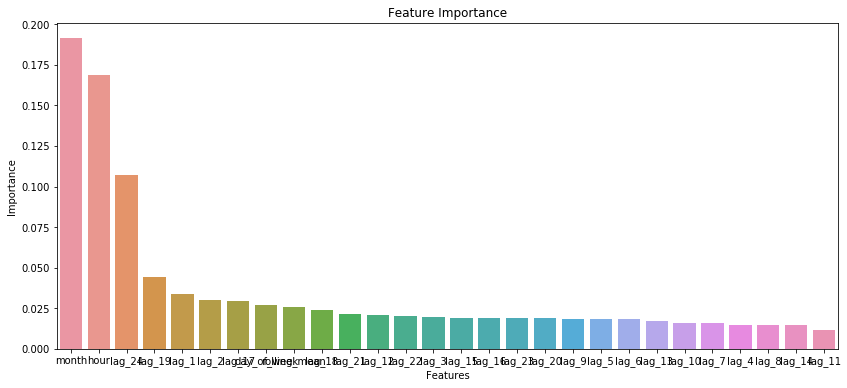

In [37]:

importance = pd.Series(data=cat_model.feature_importances_,  index=features_train.columns)
importance = importance.sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=importance.index, y=importance/sum(importance))
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Feature Importance')

## 3.3 RandomForestRegressor

In [32]:
%%time
parameters = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
}

grid_forest = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), param_grid=parameters,
                   scoring='neg_mean_squared_error', 
                   cv=TimeSeriesSplit(n_splits=2).split(features_train), verbose=True)

grid_forest.fit(features_train, target_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.4min finished


CPU times: user 3min 33s, sys: 205 ms, total: 3min 33s
Wall time: 3min 34s


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f196ec022d0>,
             error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=-1,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_j

In [33]:
print("Forest best RMSE :", (-grid_forest.best_score_)**0.5)

Forest best RMSE : 34.573492346904494


## Итоги раздела 3.

In [34]:
lin_result = lin_rmse
cat_result = cat_rmse
forest_result = (-grid_forest.best_score_)**0.5

results = pd.DataFrame(data=[lin_result, cat_result, forest_result], columns=['RMSE'],
                       index=['linear','catboost', 'random_forese'])

In [35]:
results

,RMSE
linear,37.201979
catboost,29.876900
random_forese,34.573492


Мы видим, что наилучший результат на валидационной выборке показывает catboost.

# 4. Тестирование

Воспользуемся отложенными данными для тестирования получившейся модели.

Значения метрики RMSE на тестовой выборке 47.75


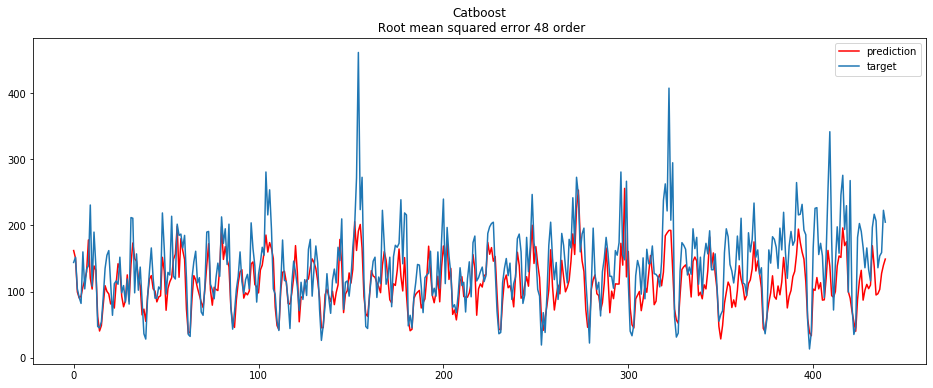

In [36]:
test_predict = cat_model.predict(features_test)

test_rmse = mean_squared_error(test_predict, target_test)**0.5

print('Значения метрики RMSE на тестовой выборке {:.2f}'.format(test_rmse))

plt.figure(figsize=(16, 6))
plt.plot(test_predict, "r", label="prediction")
plt.plot(target_test.values, label="target")
plt.legend(loc="best")

plt.title("Catboost\n Root mean squared error {} order".format(round(test_rmse)));


# Выводы.
Мы провели анализ полученных данных и построили модель предсказаняи спроса такси в аэропортах. Подобрав гиперпараметры, мы смогли добиться требуемого значения метрики RMSE. 

Лучше всего показала себя модель catboost со следующими параметрами:

    'depth': 4,
    'l2_leaf_reg': 1,
    'iterations': 700,
    'learning_rate': 0.3

По предсказаниям на тестовой выборке мы видим, что чем дальше от имеющихся у нас данных, тем сильнее расхождение между ошибками модели.

Стоит выделить, что имеющийся у нас отрезок данных включает в себя только половину года, следовательно, модель будет неправильно предсказывать на данных тех месяцев, которых у нее не было. Текущий тренд будет давать постоянное возрастание количества вызовов.


